/var/folders/ld/1rqk5svj313d3ht54zmsg1sw0000gn/T/ipykernel_15326/3147348448.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(winsorize_group)


Condition-level summary:
   cond  mean_acc    sd_acc   mean_rt     sd_rt  mean_z_rt
0   1.0  0.895737  0.109816  1.585968  0.339822  -0.660739
1   2.0  0.946856  0.025828  2.203226  0.468222   0.660739

Correlation between mean accuracy and mean RT (across subj × cond):
          mean_acc   mean_rt
mean_acc  1.000000 -0.051666
mean_rt  -0.051666  1.000000

RT: 1.0 vs 2.0 – t=-13.25, p=0.0000
Accuracy: 1.0 vs 2.0 – t=-3.65, p=0.0005


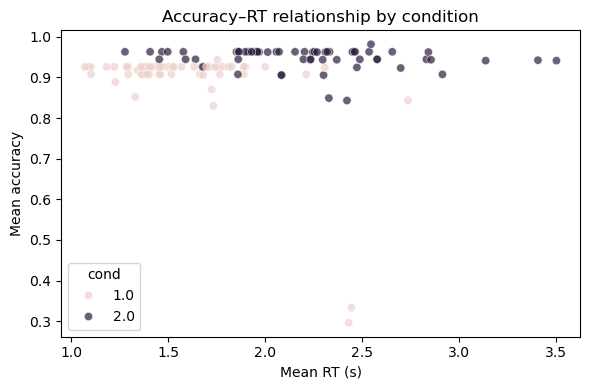

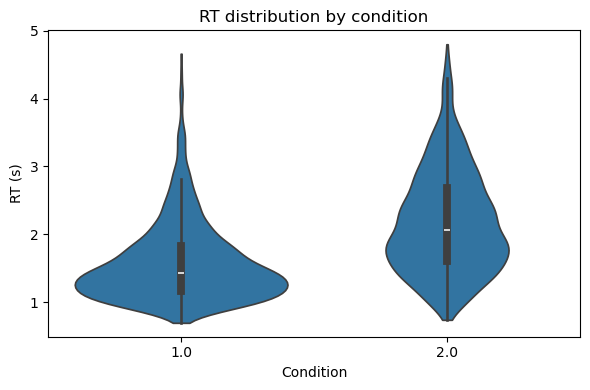

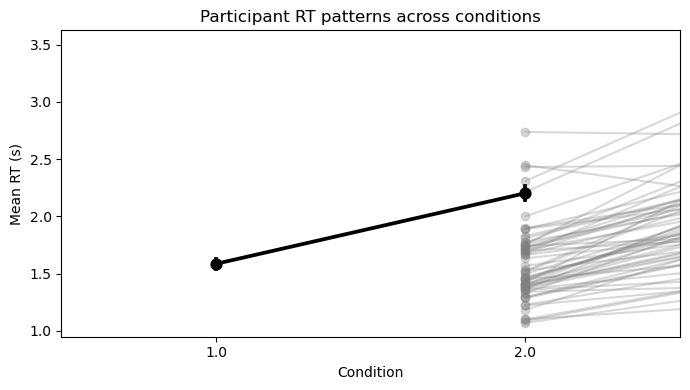

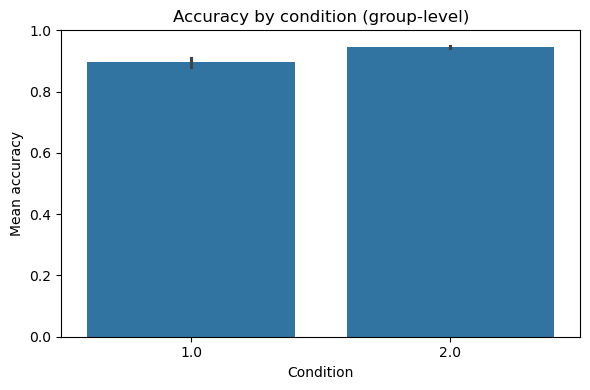

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Load and combine data
folder = "/Users/simonscholar/Downloads/Bunge_Lab_Data1"

dfs = []
for fname in os.listdir(folder):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder, fname))
        df["source_file"] = fname  # track provenance
        dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# 2. Basic filtering/cleaning

# Filter valid responses: only 'f' and 'j'
data = data.copy()
data = data[data["key_resp_2.keys"].isin(["f", "j"])]

# Drop trials with missing RT or correctness
data = data.dropna(subset=["key_resp_2.rt", "key_resp_2.corr"])

# Coerce types
data["key_resp_2.rt"] = pd.to_numeric(data["key_resp_2.rt"], errors="coerce")
data["key_resp_2.corr"] = pd.to_numeric(data["key_resp_2.corr"], errors="coerce")
data = data.dropna(subset=["key_resp_2.rt", "key_resp_2.corr"])

# Accuracy as 0/1
data["acc"] = data["key_resp_2.corr"].astype(int)

# 3. Outlier handling (winsorize RT within subject × condition)

def winsorize_group(g, col="key_resp_2.rt", lower=0.05, upper=0.95):
    lo = g[col].quantile(lower)
    hi = g[col].quantile(upper)
    g[col] = g[col].clip(lo, hi)
    return g

data = (
    data
    .groupby(["participant", "cond"], group_keys=False)
    .apply(winsorize_group)
)

# Log RT (common in RT analyses)
data["log_rt"] = np.log(data["key_resp_2.rt"])

# 4. Subject × condition summaries

summary = (
    data
    .groupby(["participant", "cond"])
    .agg(
        n_trials=("acc", "count"),
        mean_acc=("acc", "mean"),
        mean_rt=("key_resp_2.rt", "mean"),
        sd_rt=("key_resp_2.rt", "std"),
        mean_log_rt=("log_rt", "mean"),
    )
    .reset_index()
)

# Z-score RT within each participant to remove between‑subject speed differences
summary["z_rt_within_subj"] = summary.groupby("participant")["mean_rt"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# 5. Condition‑level aggregates

cond_summary = (
    summary
    .groupby("cond")
    .agg(
        mean_acc=("mean_acc", "mean"),
        sd_acc=("mean_acc", "std"),
        mean_rt=("mean_rt", "mean"),
        sd_rt=("mean_rt", "std"),
        mean_z_rt=("z_rt_within_subj", "mean"),
    )
    .reset_index()
)

print("Condition-level summary:")
print(cond_summary)

# Save summary tables
cond_summary.to_csv(os.path.join(folder, "cond_summary.csv"), index=False)
summary.to_csv(os.path.join(folder, "participant_condition_summary.csv"), index=False)

# 6. Accuracy–RT tradeoff analysis

print("\nCorrelation between mean accuracy and mean RT (across subj × cond):")
print(summary[["mean_acc", "mean_rt"]].corr())

# 7. Simple inferential tests (paired t‑tests)

# Pivot to wide format: one col per condition per participant
rt_wide = summary.pivot(index="participant", columns="cond", values="mean_rt")
acc_wide = summary.pivot(index="participant", columns="cond", values="mean_acc")

# Remove participants missing any condition
rt_wide = rt_wide.dropna()
acc_wide = acc_wide.dropna()

conds = list(rt_wide.columns)
if len(conds) == 2:
    c1, c2 = conds

    t_rt, p_rt = stats.ttest_rel(rt_wide[c1], rt_wide[c2])
    t_acc, p_acc = stats.ttest_rel(acc_wide[c1], acc_wide[c2])

    print(f"\nRT: {c1} vs {c2} – t={t_rt:.2f}, p={p_rt:.4f}")
    print(f"Accuracy: {c1} vs {c2} – t={t_acc:.2f}, p={p_acc:.4f}")
else:
    print(
        "\nMore than two conditions detected:",
        conds,
        "\nConsider repeated‑measures ANOVA or mixed‑effects models."
    )

# 8. Visualizing + saving figures

output_dir = os.path.join(folder, "plots")
os.makedirs(output_dir, exist_ok=True)

# 8a. Accuracy–RT scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=summary,
    x="mean_rt",
    y="mean_acc",
    hue="cond",
    alpha=0.7
)
plt.xlabel("Mean RT (s)")
plt.ylabel("Mean accuracy")
plt.title("Accuracy–RT relationship by condition")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "accuracy_rt_scatter.png"), dpi=300)
plt.show()
plt.close()

# RT distributions by condition (violin)
plt.figure(figsize=(6, 4))
sns.violinplot(
    data=data,
    x="cond",
    y="key_resp_2.rt",
    inner="box",
    cut=0
)
plt.xlabel("Condition")
plt.ylabel("RT (s)")
plt.title("RT distribution by condition")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "rt_violin_by_condition.png"), dpi=300)
plt.show()
plt.close()

# Participant trajectories across conditions (RT)
plt.figure(figsize=(7, 4))
for pid, sub in summary.groupby("participant"):
    plt.plot(sub["cond"], sub["mean_rt"], marker="o", alpha=0.3, color="gray")

sns.pointplot(
    data=summary,
    x="cond",
    y="mean_rt",
    color="black",
    errorbar="se"
)
plt.xlabel("Condition")
plt.ylabel("Mean RT (s)")
plt.title("Participant RT patterns across conditions")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "participant_rt_trajectories.png"), dpi=300)
plt.show()
plt.close()

# Accuracy by condition (group-level)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=summary,
    x="cond",
    y="mean_acc",
    estimator=np.mean,
    errorbar="se"
)
plt.ylim(0, 1)
plt.xlabel("Condition")
plt.ylabel("Mean accuracy")
plt.title("Accuracy by condition (group-level)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "accuracy_bar_by_condition.png"), dpi=300)
plt.show()
plt.close()